In [1]:
import pandas as pd
import geopandas as gpd
from osgeo import osr, gdal
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme(style="darkgrid")
from scipy.interpolate import griddata
import rasterio
from rasterio.plot import show
import georasters as gr

/Users/ngochoang/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.1-CAPI-1.13.3) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
file = gr.from_file('../Week 6/Elevation.tif')
elevation_df = file.to_geopandas()

In [3]:
habitat_path = r"../Week 6/UAE_habitats_new1.shp"
habitat = gpd.read_file(habitat_path)

In [4]:
elevation_df.to_crs(habitat.crs, inplace=True)

## Cropping habitat map: using bounding box

Habitat map is bigger than elevation map. A boundary needs to be created using elevation, then used to crop habitat map.\
Relevant links:
- https://automating-gis-processes.github.io/CSC18/lessons/L4/point-in-polygon.html#point-in-polygon-using-geopandas
- https://stackoverflow.com/questions/63369715/filter-a-geopandas-dataframe-within-a-polygon-and-remove-from-the-dataframe-the

<strong>Goals:</strong>
- Create a polygon (a rectangular bounding box) from the boundaries of elevation map
- Filter habitat map and retain only rows that intersect with this polygon

In [5]:
elev_bounds = elevation_df.total_bounds
elev_bounds

array([54.01375024, 24.21180533, 54.70013918, 24.70013871])

In [6]:
from shapely.geometry import Point, Polygon

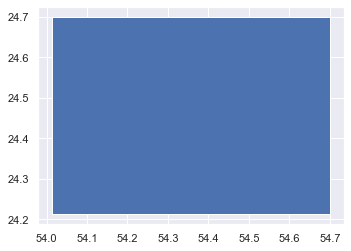

In [7]:
# Create boundary points
# Top left - top right - bottom right - bottom left
tl = Point(elev_bounds[0], elev_bounds[3])
tr = Point(elev_bounds[2], elev_bounds[3])
br = Point(elev_bounds[2], elev_bounds[1])
bl = Point(elev_bounds[0], elev_bounds[1])

boundary = Polygon([tl, tr, br, bl])

boundary_df = gpd.GeoSeries(boundary)
boundary_df.plot()
plt.show()

In [8]:
habitat['Intersection'] = habitat.geometry.intersects(boundary)

In [9]:
habitat_cut = habitat[habitat.Intersection == True]

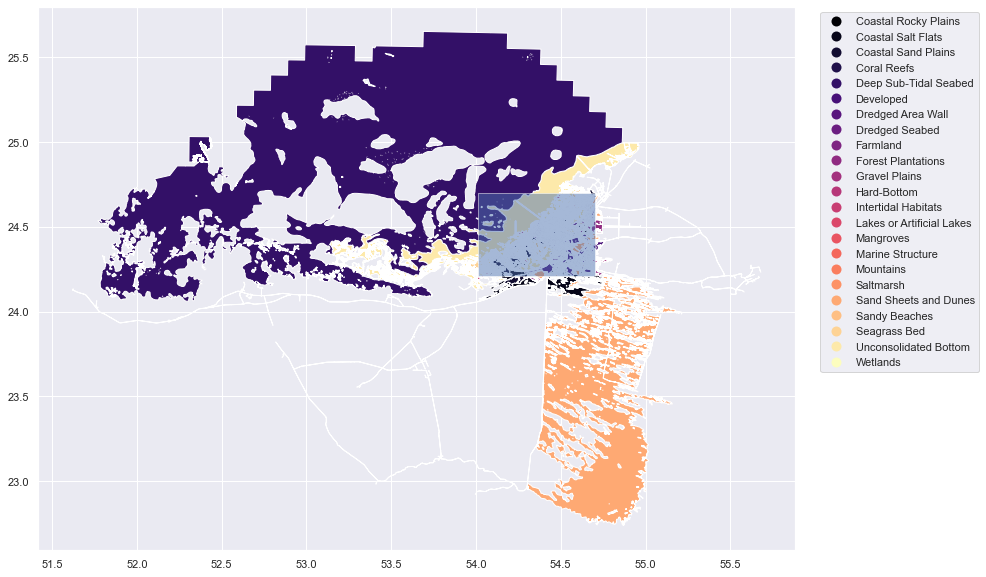

In [10]:
f, ax = plt.subplots(1, 1, figsize=(14, 10))
ax = habitat_cut.plot(column='Habitats', ax=ax, legend=True, cmap='magma')
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.25, 1))
boundary_df.plot(ax=ax, alpha=0.5)
plt.show()

Does not cut everything. Why? Are there shapes that are very complicated (the dark purple part) that does intersect with the polygon? Nonetheless the length of dataframe is much smaller now.

In [123]:
# DO NOT RUN THIS
# Takes too long
# overlay = gpd.overlay(habitat_cut, elevation_df, how='intersection')

Documentation of <code>.within()</code>: https://shapely.readthedocs.io/en/stable/manual.html#object.within

Problem: retains only rows that lie completely within the bounding box. Does not work because I need to also parts of rows that overlap with elevation. The new habitat map fits perfectly but many segments are missing.

In [13]:
# .within() takes only rows that lie
habitat['Within'] = habitat.geometry.within(boundary)

In [14]:
habitat_within = habitat[habitat.Within == True]

In [124]:
habitat_within.shape[0], habitat_cut.shape[0]

(6891, 7057)

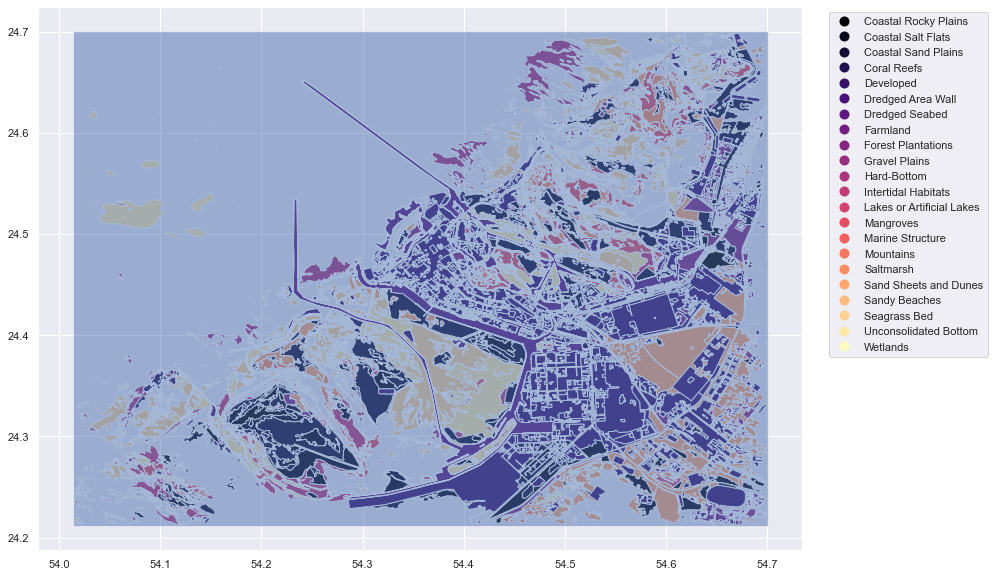

In [16]:
f, ax = plt.subplots(1, 1, figsize=(14, 10))
ax = habitat_within.plot(column='Habitats', ax=ax, legend=True, cmap='magma')
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.25, 1))
boundary_df.plot(ax=ax, alpha=0.5)
plt.show()

Circling back to GeoTiff a bit:

In [18]:
# from raster2xyz.raster2xyz import Raster2xyz

# input_raster = "../Week 6/Elevation.tif"
# out_csv = "elev.csv"

# rtxyz = Raster2xyz()
# rtxyz.translate(input_raster, out_csv)

# myRasterDF = pd.read_csv(out_csv)

In [19]:
# myRasterDF.shape

This is the same as reading as array. I need to reduce the number of points not increasing them.

## Trying <code>griddata</code> (did not finish this)

In [17]:
dataset = rasterio.open('../Week 6/Elevation.tif')
elevation_matrix = dataset.read(1)

In [18]:
x_min_elev = elev_bounds[0]
x_max_elev = elev_bounds[2]
y_min_elev = elev_bounds[1]
y_max_elev = elev_bounds[3]

In [19]:
nyy, nxx = elevation_matrix.shape
xx = np.linspace(x_min_elev, x_max_elev, nxx)
yy = np.linspace(y_min_elev, y_max_elev, nyy)
xxv, yyv = np.meshgrid(xx, yy)

In [20]:
xxv.shape, yyv.shape

((1758, 2521), (1758, 2521))

In [21]:
habitat.head(2)

,OBJECTID,Id,HabitatTyp,HabitatT_1,HabitatSub,HabitatS_1,RuleID,Shape_Leng,Shape_Area,Habitats,geometry,Intersection,Within
0,1,1,1000,Intertidal Habitats,1010,Mudflats And Sand Exposed At Low Tide,14,7524.321019,2.115300e+06,Intertidal Habitats,"POLYGON ((53.99011 24.13066, 53.99039 24.13065...",False,False
1,2,2,1000,Intertidal Habitats,1010,Mudflats And Sand Exposed At Low Tide,14,48704.931412,7.777595e+06,Intertidal Habitats,"POLYGON ((54.07207 24.15920, 54.07776 24.15455...",False,False


In [25]:
# Placeholder

## Cropping habitat map: using specific elevation polygon

Relevant links:
- https://stackoverflow.com/questions/40385782/make-a-union-of-polygons-in-geopandas-or-shapely-into-a-single-geometry
- https://geopandas.org/docs/user_guide/aggregation_with_dissolve.html

<strong>Goals:</strong>
- Create a polygon (NOT a rectangular bounding box) from all the geometries of elevation map
- Filter habitat map and retain only rows that intersect with this polygon
- Instead of comparing every habitat row against every elevation row, only need to compare habitat rows against one elevation polygon
- Similar to using bounding box, but the polygon is the specific shape of elevation map, not just the rectangular boundaries

In [22]:
elevation_df.head()

,row,col,value,x,y,geometry
0,0,2347,1.0,54.651806,24.700139,"POLYGON ((54.65181 24.70014, 54.65208 24.70014..."
1,0,2348,0.0,54.652084,24.700139,"POLYGON ((54.65208 24.70014, 54.65236 24.70014..."
2,0,2349,1.0,54.652361,24.700139,"POLYGON ((54.65236 24.70014, 54.65264 24.70014..."
3,0,2350,1.0,54.652639,24.700139,"POLYGON ((54.65264 24.70014, 54.65292 24.70014..."
4,0,2351,2.0,54.652917,24.700139,"POLYGON ((54.65292 24.70014, 54.65319 24.70014..."


In [24]:
from shapely.ops import cascaded_union

In [28]:
# Example
# polys1 = gpd.GeoSeries([Polygon([(0,0), (2,0), (2,2), (0,2)]),
#                          Polygon([(2,2), (4,2), (4,4), (2,4)])])

# polys2 = gpd.GeoSeries([Polygon([(1,1), (3,1), (3,3), (1,3)]),
#                          Polygon([(3,3), (5,3), (5,5), (3,5)])])
# polygons = [polys1[0], polys1[1], polys2[0], polys2[1]]
# boundary = gpd.GeoSeries(cascaded_union(polygons))
# boundary.plot(color = 'red')
# plt.show()
# polygons

In [25]:
elev_union_shape = cascaded_union(list(elevation_df.geometry))
elev_union = gpd.GeoSeries(elev_union_shape)

In [26]:
elev_union_df = gpd.GeoDataFrame({'geometry': elev_union})
elev_union_df.crs = habitat.crs
elev_union_df

,geometry
0,"MULTIPOLYGON (((54.70014 24.21208, 54.70014 24..."


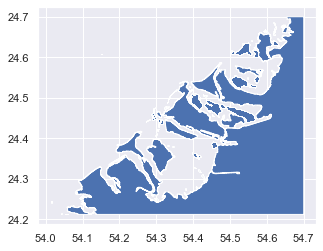

In [126]:
# The below is ONE polygon
elev_union_df.plot()
plt.show()

Note: below graph has
- In colors: habitat map reduced to rows that <strong>intersect</strong> elevation
- In blue: elevation bounding box
- In red: elevation polygon

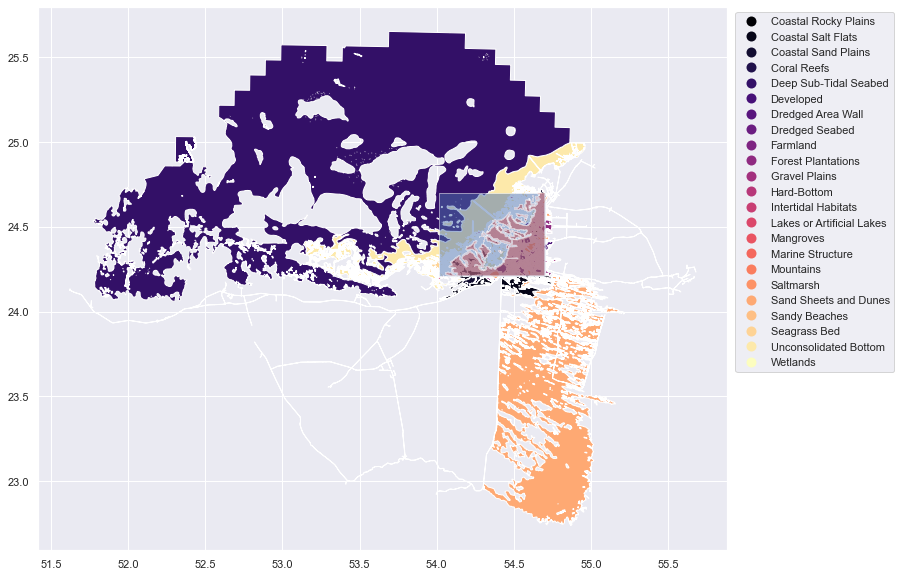

In [130]:
f, ax = plt.subplots(1, 1, figsize=(14, 10))
ax = habitat_cut.plot(column='Habitats', ax=ax, legend=True, cmap='magma')
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.25, 1))
boundary_df.plot(ax=ax, alpha=0.5)
elev_union_df.plot(ax=ax, alpha=0.5, color='r')
plt.show()

Note: below graph has
- In colors: habitat map reduced to rows that <strong>lie within</strong> elevation
- In blue: elevation bounding box
- In red: elevation polygon

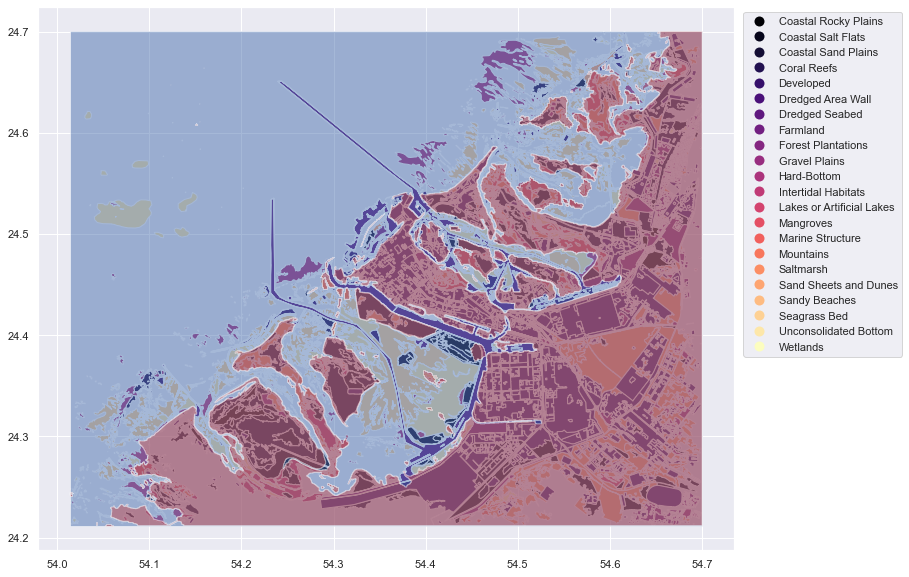

In [129]:
f, ax = plt.subplots(1, 1, figsize=(14, 10))
ax = habitat_within.plot(column='Habitats', ax=ax, legend=True, cmap='magma')
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.25, 1))
boundary_df.plot(ax=ax, alpha=0.5)
elev_union_df.plot(ax=ax, alpha=0.5, color='r')
plt.show()

In [27]:
elev_union_df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [30]:
elev_union.crs = habitat.crs
elev_union_shape.crs = habitat.crs

Filter out all the rows in habitat that intersect with elevation polygon. Using <code>habitat_cut</code> (rows that overlap with bounding box) to save running time. Documentation of <code>.intersects()</code>: https://shapely.readthedocs.io/en/stable/manual.html#object.intersects

In [44]:
habitat_cut['Intersection_2'] = habitat_cut.geometry.intersects(elev_union_shape)

/Users/ngochoang/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [47]:
habitat_cut.Intersection_2.value_counts()

True     4798
False    2259
Name: Intersection_2, dtype: int64

In [48]:
habitat_cut_cut = habitat_cut[habitat_cut['Intersection_2'] == True]

In [49]:
habitat_cut_cut

,OBJECTID,Id,HabitatTyp,HabitatT_1,HabitatSub,HabitatS_1,RuleID,Shape_Leng,Shape_Area,Habitats,geometry,Intersection,Intersection_2
8,9,9,1000,Intertidal Habitats,1010,Mudflats And Sand Exposed At Low Tide,14,5.543213e+03,2.599118e+05,Intertidal Habitats,"POLYGON ((54.13561 24.20157, 54.13545 24.20108...",True,True
9,10,10,1000,Intertidal Habitats,1010,Mudflats And Sand Exposed At Low Tide,14,1.505177e+04,5.783279e+05,Intertidal Habitats,"POLYGON ((54.14235 24.20912, 54.14226 24.20910...",True,True
10,11,11,1000,Intertidal Habitats,1010,Mudflats And Sand Exposed At Low Tide,14,1.373617e+04,2.348295e+06,Intertidal Habitats,"POLYGON ((54.07886 24.20702, 54.07862 24.20700...",True,True
11,12,12,1000,Intertidal Habitats,1010,Mudflats And Sand Exposed At Low Tide,14,1.287492e+03,5.439819e+04,Intertidal Habitats,"POLYGON ((54.11495 24.22756, 54.11492 24.22753...",True,True
12,13,13,1000,Intertidal Habitats,1010,Mudflats And Sand Exposed At Low Tide,14,7.051029e+03,9.375957e+05,Intertidal Habitats,"POLYGON ((54.13259 24.22972, 54.13271 24.22969...",True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68259,68260,27601,16000,Dredged Areas,16200,Dredged Area Wall,12,2.551663e+04,2.512130e+04,Dredged Area Wall,"POLYGON ((54.62921 24.62922, 54.62921 24.62922...",True,True
68260,68261,27602,16000,Dredged Areas,16200,Dredged Area Wall,12,9.794738e+02,9.398685e+02,Dredged Area Wall,"POLYGON ((54.66559 24.68667, 54.66557 24.68659...",True,True
68261,68262,27603,16000,Dredged Areas,16200,Dredged Area Wall,12,9.171414e+02,9.132340e+02,Dredged Area Wall,"POLYGON ((54.65379 24.69573, 54.65438 24.69566...",True,True
68262,68263,27604,16000,Dredged Areas,16200,Dredged Area Wall,12,3.178273e+03,3.125444e+03,Dredged Area Wall,"POLYGON ((54.65339 24.69422, 54.65367 24.69395...",True,True


In [52]:
habitat_cut_cut.to_csv('habitat_cut_cut.csv', index=False)

Plotting all habitat rows that intersect elevation polygon:

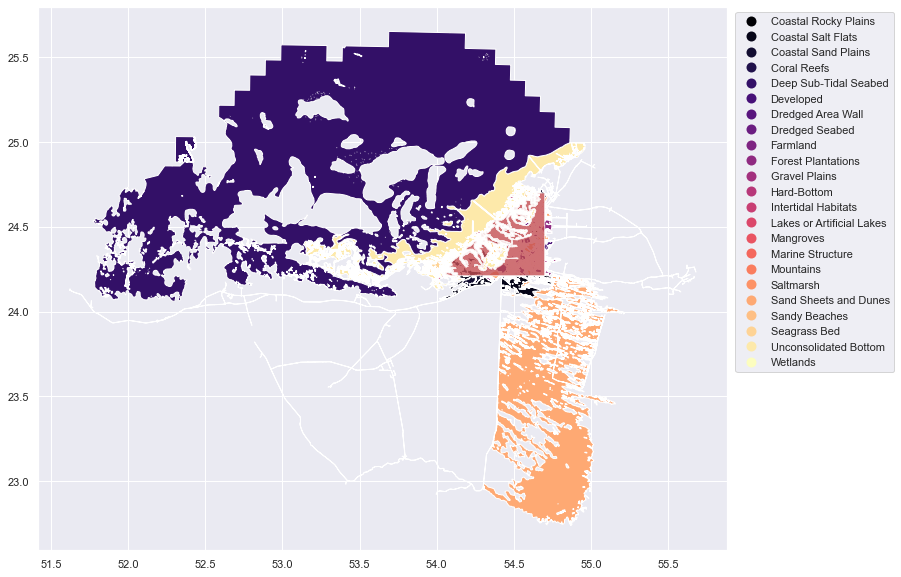

In [133]:
f, ax = plt.subplots(1, 1, figsize=(14, 10))
ax = habitat_cut.plot(column='Habitats', ax=ax, legend=True, cmap='magma')
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.25, 1))
elev_union.plot(ax=ax, alpha=0.8, color='r')
plt.show()

Why are there still many big segments lying far from elevation polygon? Are there big shapes that intersect very briefly with elevation still? Plotting one of the big segments:

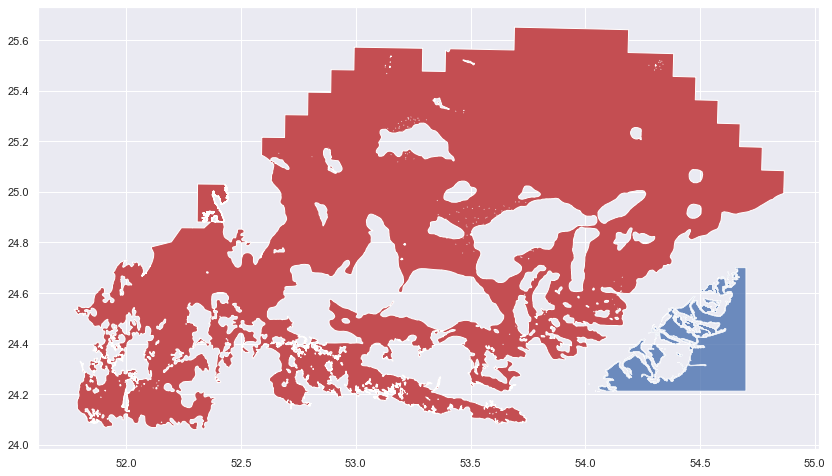

In [76]:
f, ax = plt.subplots(1, 1, figsize=(14, 10))
# ax = habitat_cut.plot(column='Habitats', ax=ax, legend=True)
elev_union.plot(ax=ax, alpha=0.8)
habitat_cut_cut[habitat_cut_cut.Habitats == "Deep Sub-Tidal Seabed"].plot(ax=ax, color='r')
plt.show()

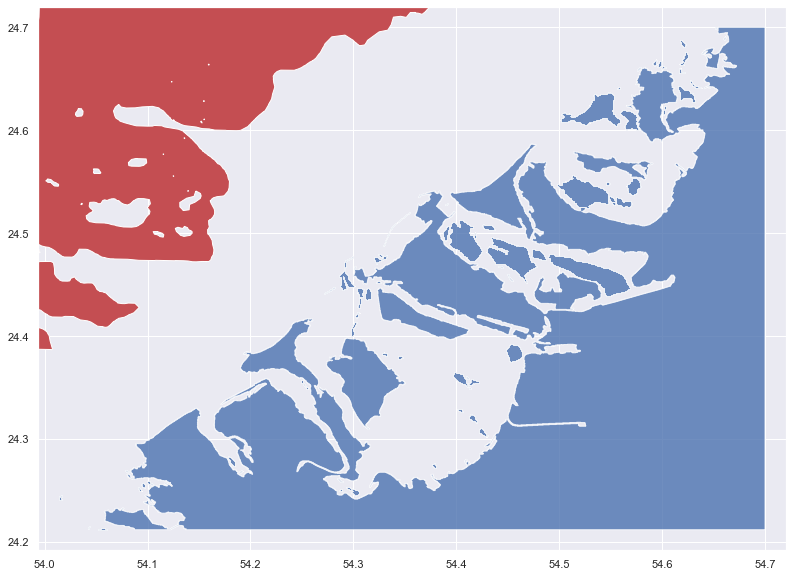

In [75]:
f, ax = plt.subplots(1, 1, figsize=(14, 10))
# ax = habitat_cut.plot(column='Habitats', ax=ax, legend=True)
elev_union.plot(ax=ax, alpha=0.8)
habitat_cut_cut[habitat_cut_cut.Habitats == "Deep Sub-Tidal Seabed"].plot(ax=ax, color='r')
ax.imshow(elevation_matrix, extent=(x_min_elev-0.02, x_max_elev+0.02, y_min_elev-0.02, y_max_elev+0.02), alpha=0)
plt.show()

I still can't see where they intersect. But apparently they do. Still, the new reduced habitat dataframe has only 4798 points. Good enough for overlaying.

## Overlaying the reduced habitat map with elevation

### <code>sjoin()</code>

In [112]:
join_inner_df = gpd.sjoin(habitat_cut_cut, elev_union_df, how="inner")
join_inner_df.shape

(4798, 14)

In [99]:
# join_inner_df.to_csv('join_inner_df.csv', index=False)

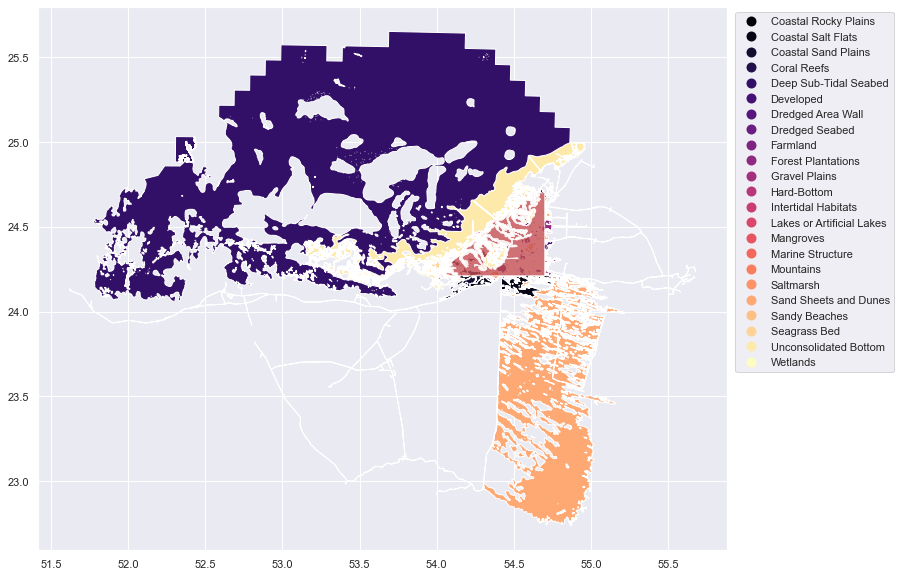

In [134]:
f, ax = plt.subplots(1, 1, figsize=(14, 10))
ax = join_inner_df.plot(column='Habitats', ax=ax, legend=True, cmap='magma')
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.25, 1))
elev_union.plot(ax=ax, alpha=0.8, color='r')
plt.show()

Why is it big still? Trying out left sjoin, same result.

In [114]:
join_left_df = gpd.sjoin(elev_union_df, habitat_cut_cut, how="left", op="intersects")
join_left_df.shape

(4798, 14)

### <code>overlay()</code>

In [115]:
intersection = gpd.overlay(habitat_cut_cut, elev_union_df, how='intersection')

In [116]:
intersection.to_csv('intersection.csv', index=False)

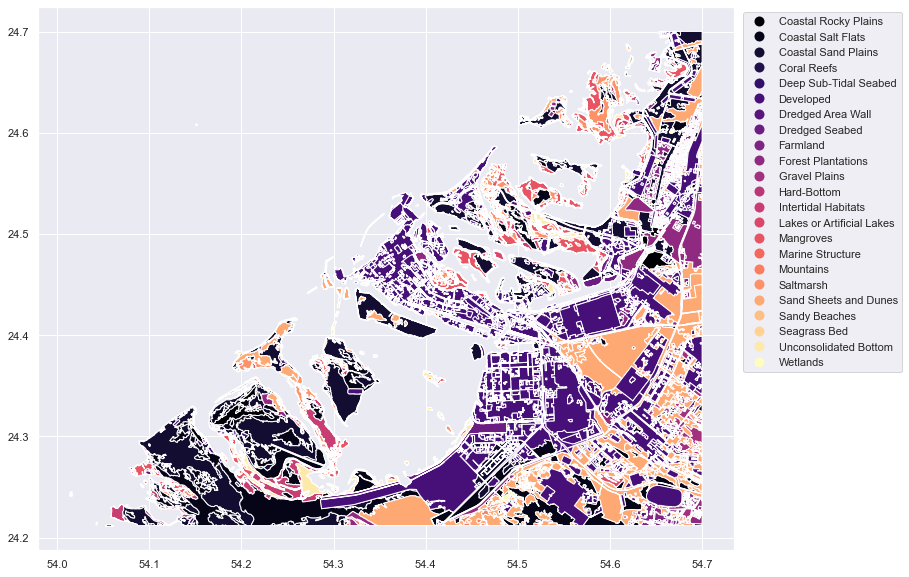

In [122]:
f, ax = plt.subplots(1, 1, figsize=(14, 10))
ax = intersection.plot(column='Habitats', ax=ax, legend=True, cmap='magma')
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.25, 1))
plt.show()

## Network - Vertical land movement

Interpolation code in July 3 notebook

In [ ]:
inter_vlm = np.genfromtxt('../Week 6/interpolated_vlm.csv', delimiter=',')

In [ ]:
inter_vlm

In [ ]:
plt.imshow(inter_vlm, origin='lower', alpha=0.8)
plt.show()

In [ ]:
inter_vlm.shape

In [ ]:
inter_vlm_df = pd.DataFrame(inter_vlm.flatten(), columns=['VLM'])

In [ ]:
inter_vlm_df.dropna(inplace=True)
inter_vlm_df

In [ ]:
inter_vlm_df['Bins'] = pd.qcut(inter_vlm_df.VLM, q=3, labels=['Bin 1', 'Bin 2', 'Bin 3'])
inter_vlm_df['Intervals'] = pd.qcut(inter_vlm_df.VLM, q=3)
inter_vlm_df.head()

In [ ]:
inter_vlm_df.Intervals.value_counts()

In [ ]:
vlm_bins = pd.DataFrame(inter_vlm_df.Bins.value_counts())
vlm_bins['Probability'] = vlm_bins.Bins / vlm_bins.Bins.sum()
vlm_bins

In [ ]:
vlm_statenames = list(vlm_bins.index)
vlm_statenames